In [105]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle

pd.set_option('display.max_columns', None)

In [190]:
import os
os.chdir('/home/marylena/Documents/ConsultingProject')
df = pd.read_pickle('merged_df.pkl')
df.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State,amount,award_count,per_capita,population,shape_code,countyFIPS,StateFIPS,2021-03-21,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,% female,log private ins,log public ins,log no ins
0,0500000US01003,Baldwin County,220911,106961,113950,189325,17668,N,N,N,N,N,183610,N,10616,36210,40659,86588,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050,N,N,N,N,N,27581,N,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,N,N,N,N,N,15.0,N,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3.5,11.2,5.0,5.7,4.6,6.8,3.6,5.7,2.6,10.5,7.6,0.0,5.9,1.7,7.9,17.8,12.3,26.4,2.9,1.5,2.0,1.0,2.4,6.6,3.6,11.4,6.2,3.5,3.0,3.8,13.4,7.4,22.9,AL,4.4

In [191]:
newacs = pd.read_csv('newACS.csv', index_col=0)
newacs['State'] = newacs.index
newacs['State'] = newacs.State.apply(lambda x: x[x.find(',')+2:])
newacs['State'] = newacs.State.apply(lambda x: x[:x.find(':')])
newacs['county_name'] = [newacs.index[x].split(",")[0] for x in range(len(newacs.index))]

newacs['State'] = newacs['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)

newacs.head()

,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,State,county_name
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,4058,46650,41.9,20245,1007,68,116,28,403,13,IL,Fayette County
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,5224,57308,40.1,25667,2003,73,218,10,985,230,IL,Logan County
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,4785,44090,42.2,22234,632,53,178,54,428,122,IL,Saline County
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,96339,89427,38.4,531609,47385,2162,54157,285,152141,45309,IL,Lake County
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,2962,47481,43.5,12956,830,6,29,0,419,0,IL,Massac County


In [192]:
#df= df.merge(newacs, how='left', on=['county_name', 'State'])
df.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State,amount,award_count,per_capita,population,shape_code,countyFIPS,StateFIPS,2021-03-21,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,% female,log private ins,log public ins,log no ins
0,0500000US01003,Baldwin County,220911,106961,113950,189325,17668,N,N,N,N,N,183610,N,10616,36210,40659,86588,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),127247,40659,86588,46838,28682,18156,31901,15573,16328,27623,2050,N,N,N,N,N,27581,N,0,2538,3850,11393,6070,8050,10749,413,0,413,3431,384,3047,6905,2782,4123,5281,626,0,626,1623,650,973,3032,997,2035,10586,2052,5880,2745,3135,2654,739,1915,15885,0,7555,690,6865,8330,3533,4797,6181,553,2534,419,2115,3094,1030,2064,10780,4500,1200,3300,6280,2131,4149,14.4,14.6,14.3,14.6,11.6,N,N,N,N,N,15.0,N,0.0,7.0,9.5,13.2,21.2,44.3,4.9,0.9,0.0,1.1,2.7,0.9,3.5,14.7,9.7,22.7,2.4,1.3,0.0,1.7,1.3,1.6,1.1,6.5,3.5,11.2,5.0,5.7,4.6,6.8,3.6,5.7,2.6,10.5,7.6,0.0,5.9,1.7,7.9,17.8,12.3,26.4,2.9,1.5,2.0,1.0,2.4,6.6,3.6,11.4,6.2,3.5,3.0,3.8,13.4,7.4,22.9,AL,4.4

In [193]:
inter = pd.read_csv('kaggle_internet.csv')
inter=inter.rename(columns={'state':'State', 'county':'county_name'})
inter.head()
dfgini = inter[['State', 'county_name','lat','lon','gini_index', 'percent_no_internet']]
dfgini.head()

,State,county_name,lat,lon,gini_index,percent_no_internet
0,AK,Anchorage Municipality,61.177549,-149.274354,0.4018,6.593887
1,AK,Fairbanks North Star Borough,64.690832,-146.599867,0.3756,12.102458
2,AK,Matanuska-Susitna Borough,62.182173,-149.407974,0.4351,11.156575
3,AL,Baldwin County,30.659218,-87.746067,0.4498,17.868167
4,AL,Calhoun County,33.771706,-85.822513,0.4692,23.464932


In [194]:
df2 = get_county_spending()

In [195]:
import plotly.express as px



df['log amount'] = np.log(df.amount)
df['log population'] = np.log(df.population)
df['log population'].isna().sum()
df=df.dropna(axis=0)

fig = px.scatter(df, y="log amount", x="log population", hover_data=["county_name", "State"])
fig.show()

df2['log amount'] = np.log(df2.amount)
df2['log population'] = np.log(df2.population)
df2['log population'].isna().sum()
df2=df2.dropna(axis=0)
df2['county_name'] = df2['display_name']

fig = px.scatter(df2, y="log amount", x="log population", hover_data=["display_name"])
fig.show()

In [196]:
from sklearn import linear_model

mod = linear_model.LinearRegression(normalize=True)

#df=df2
X = np.asarray(df['log population']).reshape((len(df.index), 1))


mod.fit(X, df['log amount'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [197]:
se =  np.mean((mod.predict(X) - df['log amount'])**2)

In [198]:
df['predictions'] = mod.predict(X)
df['outlier'] = 0

In [199]:
overfunded_counties=df['county_name'][df['log amount']> df['predictions']+3*se]

df['county_name'][df['log amount']> df['predictions']+4*se]

38                Hennepin
193                   Leon
210                 Albany
332               Sangamon
701                   Cole
962                 Juneau
1082    Carson City (City)
1264              Hodgeman
1279              San Juan
1353             Mcpherson
1519                 Sioux
1751                Hughes
1991                Borden
2285              Franklin
2566                  Kent
Name: county_name, dtype: object

In [200]:
underfunded_counties= df['county_name'][df['log amount']<df['predictions']-3*se]
#print(df['State'][df['log amount']<df['predictions']-4*se])
df['county_name'][df['log amount']<df['predictions']-4*se]

3111            Dodge
3124          Garrard
3153           Cannon
3176            Leake
3179        Jefferson
3194         Anderson
3200    Chattahoochee
3202         Harrison
3209          Hancock
3216         Atkinson
Name: county_name, dtype: object

In [158]:
df['overfunded'] = (df['log amount']> df['predictions']+4*se).astype('int64')
df['underfunded'] = (df['log amount']< df['predictions']-4*se).astype('int64')
df['overall'] = df['overfunded']-df['underfunded']
df['log covid cases'] = np.log(df['2021-03-21'])
df['log disabled'] = np.log(df['people with a disability_y'])
df['log elderly'] = np.log(df['people that are older than 65_y'])
df['log Black AA'] = np.log(df['black or african american'])
df['log asian'] = np.log(df['asian'])
df['log white'] = np.log(df['white'])
df['log indigenous'] = np.log(df['american indian and alaska native']+1)
df['% Black AA'] = np.log(df['black or african american']/df['population'])
df['% asian'] = np.log(df['asian']/df['population'])
df['% hispanic'] = np.log(df['hispanic or latino'])
#df['overfunded'][df['log amount']> df['predictions']+3*se] = 1

In [155]:
df.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State,amount,award_count,per_capita,population,shape_code,countyFIPS,StateFIPS,2021-03-21,employed people with 16 yrs and over_x,unemployed people with 16 yrs and over_x,people in the labor force_x,unemployment rate_x,people with a disability_x,people that are older than 65_x,median household income_x,median age_x,% female,log private ins,log public ins,log no ins,employed people with 16 yrs and over_y,unemployed people with 16 yrs and over_y,people in the labor force_y,unemployment rate_y,people with private health insurance,people with public health insurance,people without health insurance,people with a disability_y,male,female,people that are older than 65_y,median household income_y,median age_y,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,log amount,log population,predictions,outlier,overfunded,underfunded,overall,log covid cases,log disabled,log elderly,log Black AA,log asian,log white,% Black AA,% asian,log indigenous,% hispanic
0,0500000US01003,Baldwin County,220911,106961,113950,189325,17668,N,N,N,N,N,183610,N,10616,36210,40659,86588,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),46826,10616,36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,28682,18156,(X),36210,127247,40659,86588,46838,2

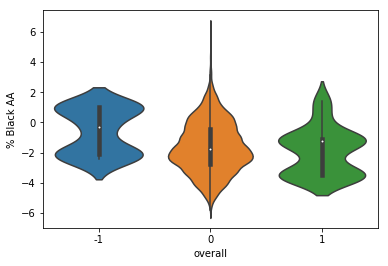

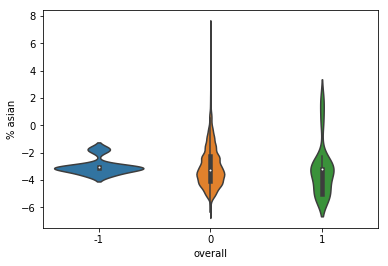

In [164]:
sns.violinplot(x='overall', y='% Black AA',data=df)
plt.show()
sns.violinplot(x='overall', y='% asian',data=df)